In [5]:
cd ..

/data/vision/beery/scratch/evelyn/task_datacomp


In [6]:
from visualizations.utils import plot_train_and_subsets, plot_test_and_subsets
import pandas as pd

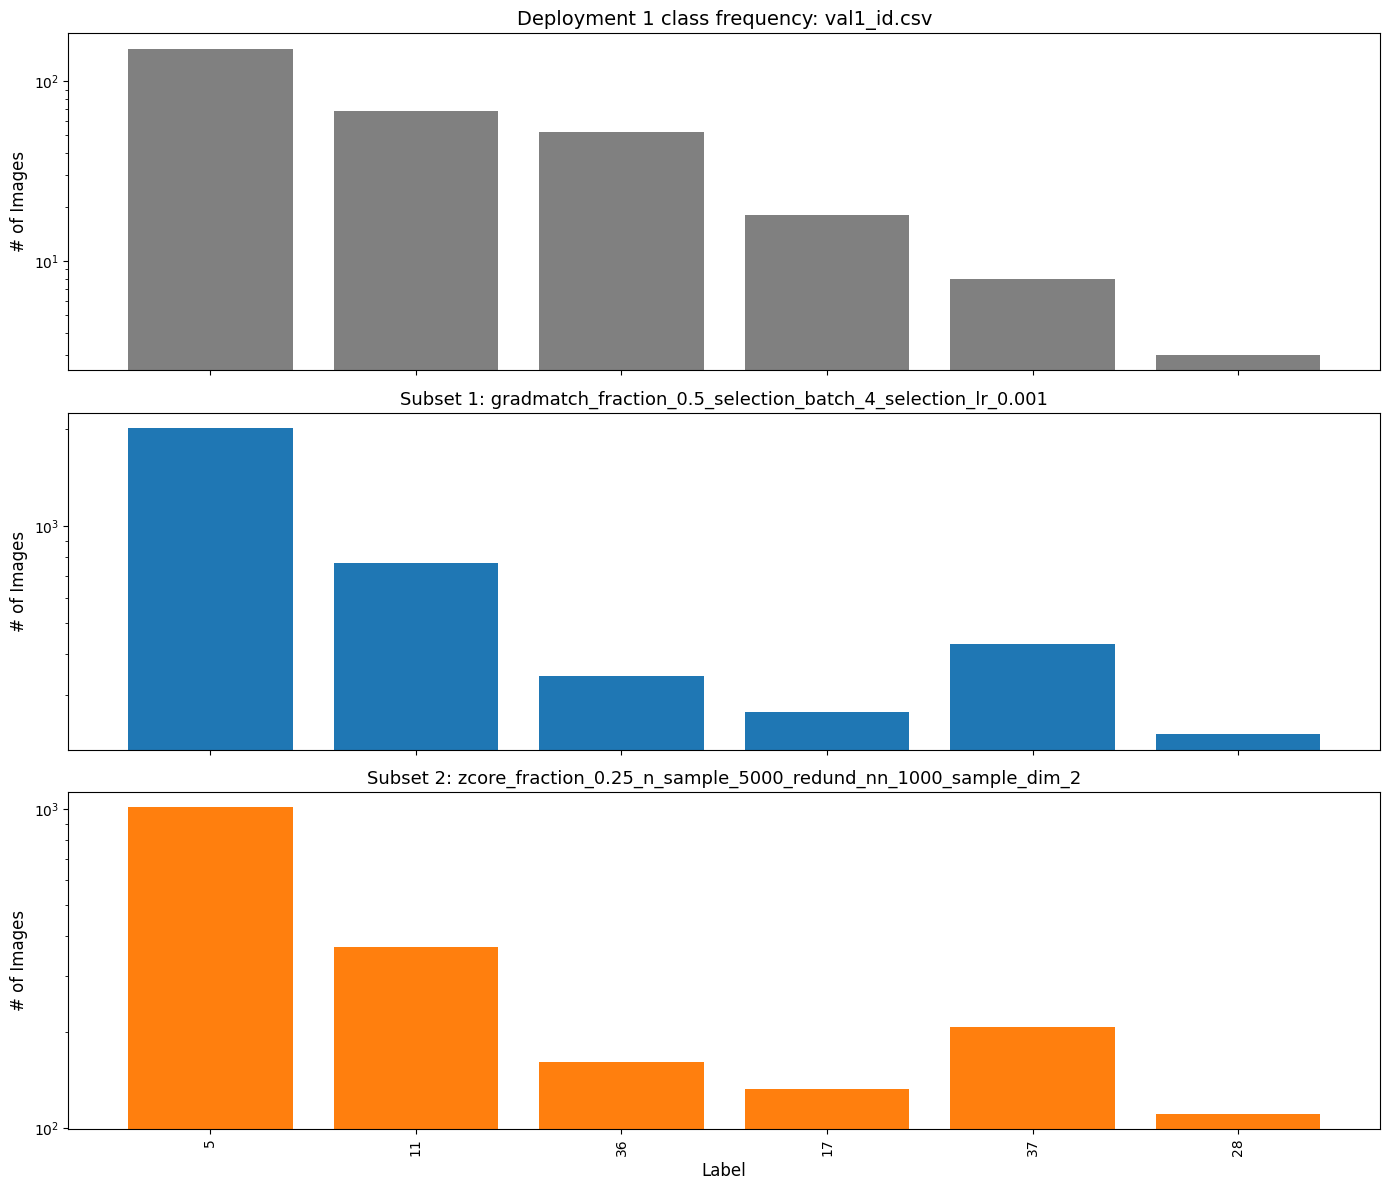

In [16]:
subset_paths = [
    "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/gradmatch_fraction_0.5_selection_batch_4_selection_lr_0.001/test1_subset.npy",
    # "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/match_dist_fraction_0.5/test1_subset.npy",
    "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/zcore_fraction_0.25_n_sample_5000_redund_nn_1000_sample_dim_2/test1_subset.npy",
    # "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/no_filter_fraction_1/test1_subset.npy",
    # "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/random_filter_fraction_0.25/test1_subset.npy",

]

plot_test_and_subsets(
    test_csv_path="/data/vision/beery/scratch/neha/task-datacomp/all_datasets/iWildCam/new_splits/val1_id.csv",
    train_csv_path="/data/vision/beery/scratch/neha/task-datacomp/all_datasets/iWildCam/new_splits/train.csv",
    subset_paths=subset_paths
)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy  # for KL divergence

def compute_label_distributions(test_csv_path, train_csv_path, subset_paths, uid_col="UID", label_col="label", top_n=50):
    """
    Computes normalized label distributions for test and subset .npy files.
    """
    # Normalize subset_paths
    if isinstance(subset_paths, str):
        subset_paths = [subset_paths]

    # Load test and train data
    test_df = pd.read_csv(test_csv_path)
    train_df = pd.read_csv(train_csv_path)

    # --- Compute test distribution ---
    test_label_counts = test_df[label_col].value_counts()
    top_labels = test_label_counts.index[:top_n]
    test_probs = np.array([test_label_counts.get(lbl, 0) for lbl in top_labels], dtype=float)
    test_probs /= test_probs.sum()

    # --- Compute each subset distribution (mapped via train.csv) ---
    subset_distributions = {}
    for path in subset_paths:
        subset_uids = np.load(path, allow_pickle=True)
        subset_df = train_df[train_df[uid_col].isin(subset_uids)]
        subset_label_counts = subset_df[label_col].value_counts()
        subset_probs = np.array([subset_label_counts.get(lbl, 0) for lbl in top_labels], dtype=float)
        subset_probs /= subset_probs.sum() if subset_probs.sum() > 0 else 1
        subset_name = os.path.basename(os.path.dirname(path))
        subset_distributions[subset_name] = subset_probs

    return top_labels, test_probs, subset_distributions


def compute_kl_divergences(test_csv_path, train_csv_path, subset_paths, uid_col="uid", label_col="category_id", top_n=50):
    """
    Computes the KL divergence between the test set and each subset distribution.
    Returns a dict mapping subset_name -> KL divergence value.
    """
    top_labels, test_probs, subset_distributions = compute_label_distributions(
        test_csv_path, train_csv_path, subset_paths, uid_col, label_col, top_n
    )

    kl_results = {}
    for subset_name, subset_probs in subset_distributions.items():
        # KL divergence (add small epsilon for numerical stability)
        eps = 1e-10
        kl = entropy(test_probs + eps, subset_probs + eps)
        kl_results[subset_name] = kl

    return kl_results


In [2]:
subset_paths = [
    "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/gradmatch_fraction_0.25_selection_batch_4_selection_lr_0.01/test1_subset.npy",
    "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/zcore_fraction_0.25_n_sample_5000_redund_nn_1000_sample_dim_2/test1_subset.npy",
]

kl_results = compute_kl_divergences(
    test_csv_path="/data/vision/beery/scratch/neha/task-datacomp/all_datasets/iWildCam/new_splits/test1_id.csv",
    train_csv_path="/data/vision/beery/scratch/neha/task-datacomp/all_datasets/iWildCam/new_splits/train.csv",
    subset_paths=subset_paths
)

for name, kl in kl_results.items():
    print(f"{name}: KL divergence = {kl:.4f}")

gradmatch_fraction_0.25_selection_batch_4_selection_lr_0.01: KL divergence = 1.5731
zcore_fraction_0.25_n_sample_5000_redund_nn_1000_sample_dim_2: KL divergence = 0.0402


In [17]:
subset_paths = [
    "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/gradmatch_fraction_0.5_selection_batch_4_selection_lr_0.001/test1_subset.npy",
    "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/match_dist_fraction_0.5/test1_subset.npy",
    # "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/no_filter_fraction_1/test1_subset.npy",
    # "/data/vision/beery/scratch/evelyn/task_datacomp/experiments/iWildCam/random_filter_fraction_0.25/test1_subset.npy",
]

kl_results = compute_kl_divergences(
    test_csv_path="/data/vision/beery/scratch/neha/task-datacomp/all_datasets/iWildCam/new_splits/test1_id.csv",
    train_csv_path="/data/vision/beery/scratch/neha/task-datacomp/all_datasets/iWildCam/new_splits/train.csv",
    subset_paths=subset_paths
)

for name, kl in kl_results.items():
    print(f"{name}: KL divergence = {kl:.4f}")

gradmatch_fraction_0.5_selection_batch_4_selection_lr_0.001: KL divergence = 1.5288
match_dist_fraction_0.5: KL divergence = 1.5261
